# `CRO` fitting

This tutorial illustrates how to use the `pyCRO` to estimate RO parameters from the observation and climate model outputs

Contact:
 - Sen Zhao (zhaos@hawaii.edu)

In [1]:
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

import os
import sys
    
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../../"))
import pyCRO
from pyCRO import RO_fitting, RO_solver, RO_analytic_std, RO_analytic_solver, RO_BWJ, func_mon_std, par_load

## Fitting to the observation/reanalysis

### Load observation ENSO timeseries

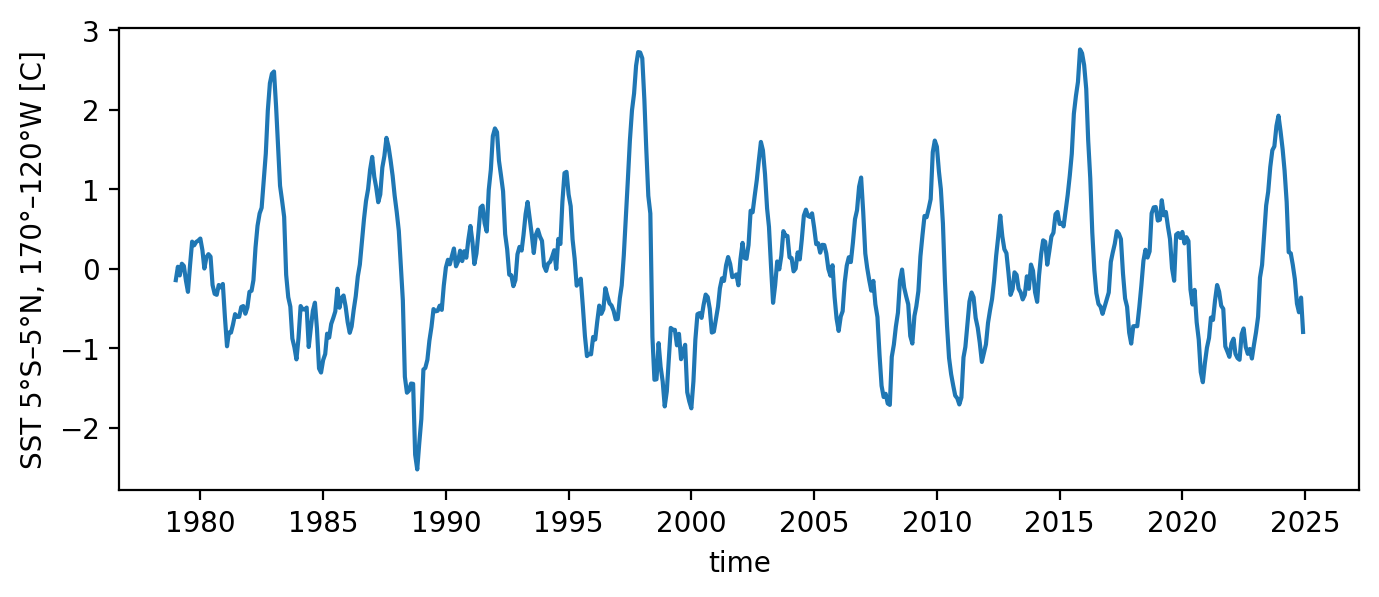

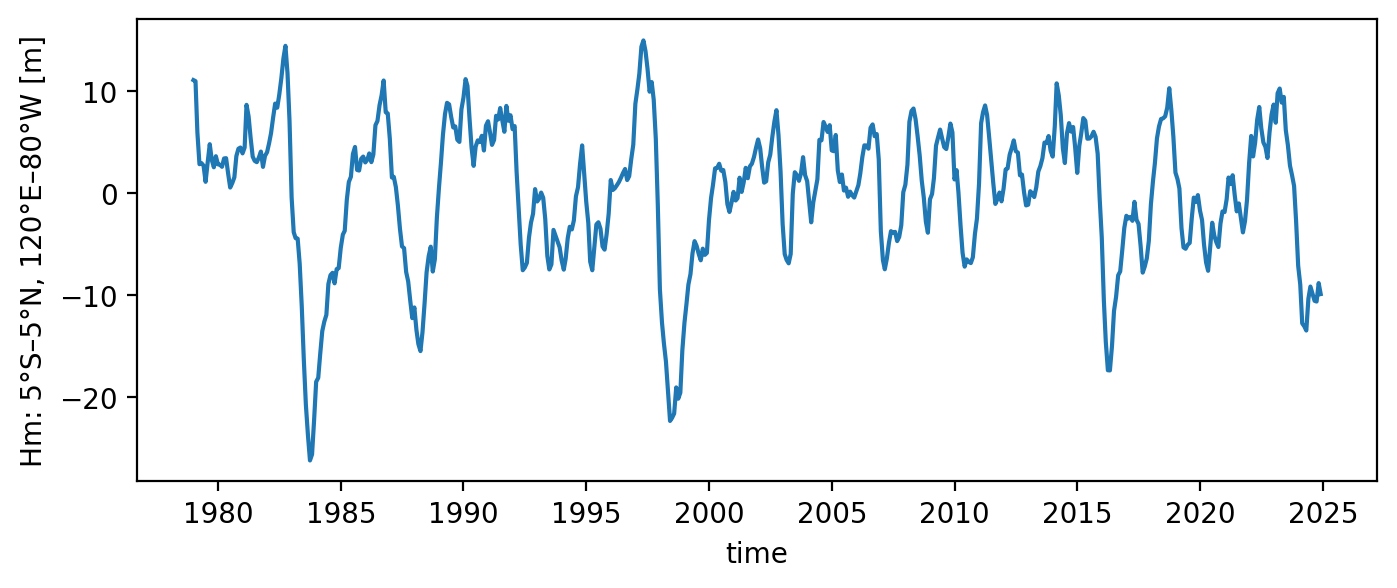

In [2]:
# load observations
file_name = os.path.join(os.getcwd(), "../../data", "XRO_indices_oras5.nc")
xr_ds = xr.open_dataset(file_name)
T_oras5 = xr_ds['Nino34'][:]  # Nino 3.4 since 1979-01-01
h_oras5 = xr_ds['WWV'][:]     # WWV since 1979-01-01
time_oras5 = xr_ds['time'][:] # Days since 1979-01-01

T_oras5.plot(figsize=(8, 3))
h_oras5.plot(figsize=(8, 3))

### Fit with type: linear RO with white addtive noise

In [14]:
# setting fitting options and print the fitted parameters
par_option_T = {"R": 3, "F1": 3, "b_T": 0, "c_T": 0, "d_T": 0}
par_option_h = {"F2": 3, "epsilon": 3, "b_h": 0}
par_option_noise = {"T": "white", "h": "white", "T_type": "additive"}

par_fitted_obs = RO_fitting(T_oras5, h_oras5, par_option_T, par_option_h, par_option_noise)
print(par_fitted_obs)

---------------------------------------------------------------------------------
Welcome to CRO Fitting! Your fitting setups:
---------------------------------------------------------------------------------
 - Data time step is not given, defaulting to: dt = 1.0 months.
 - Time series length: N = len(T)*dt = 552.0 months.
 - Prescribed terms: {'R': 3, 'F1': 3, 'b_T': 0, 'c_T': 0, 'd_T': 0}. 
                     {'F2': 3, 'epsilon': 3, 'b_h': 0}. 
   0 - Do not prescribe. 
   1 - Prescribe only the annual mean. 
   3 - Prescribe the annual mean and annual seasonality. 
   5 - Prescribe the annual mean, annual seasonality, and semi-annual seasonality.
 - Noise options: {'T': 'white', 'h': 'white', 'T_type': 'additive'}.
 - Fitting method for T and h main equations: None.
Referring to table_default_fitting_method.txt and using LR-F
---------------------------------------------------------------------------------
All steps are successfully completed!
------------------------------------

In [59]:
# setting fitting options and print the fitted parameters
par_option_T = {"R": 3, "F1": 3, "b_T": 3, "c_T": 3, "d_T": 0}
par_option_h = {"F2": 3, "epsilon": 3, "b_h": 0}
par_option_noise = {"T": "white", "h": "white", "T_type": "additive"}

par_fitted_obs2 = RO_fitting(T_oras5, h_oras5, par_option_T, par_option_h, par_option_noise)
print(par_fitted_obs2)

---------------------------------------------------------------------------------
Welcome to CRO Fitting! Your fitting setups:
---------------------------------------------------------------------------------
 - Data time step is not given, defaulting to: dt = 1.0 months.
 - Time series length: N = len(T)*dt = 552.0 months.
 - Prescribed terms: {'R': 3, 'F1': 3, 'b_T': 3, 'c_T': 3, 'd_T': 0}. 
                     {'F2': 3, 'epsilon': 3, 'b_h': 0}. 
   0 - Do not prescribe. 
   1 - Prescribe only the annual mean. 
   3 - Prescribe the annual mean and annual seasonality. 
   5 - Prescribe the annual mean, annual seasonality, and semi-annual seasonality.
 - Noise options: {'T': 'white', 'h': 'white', 'T_type': 'additive'}.
 - Fitting method for T and h main equations: None.
Referring to table_default_fitting_method.txt and using LR-F
---------------------------------------------------------------------------------
All steps are successfully completed!
------------------------------------

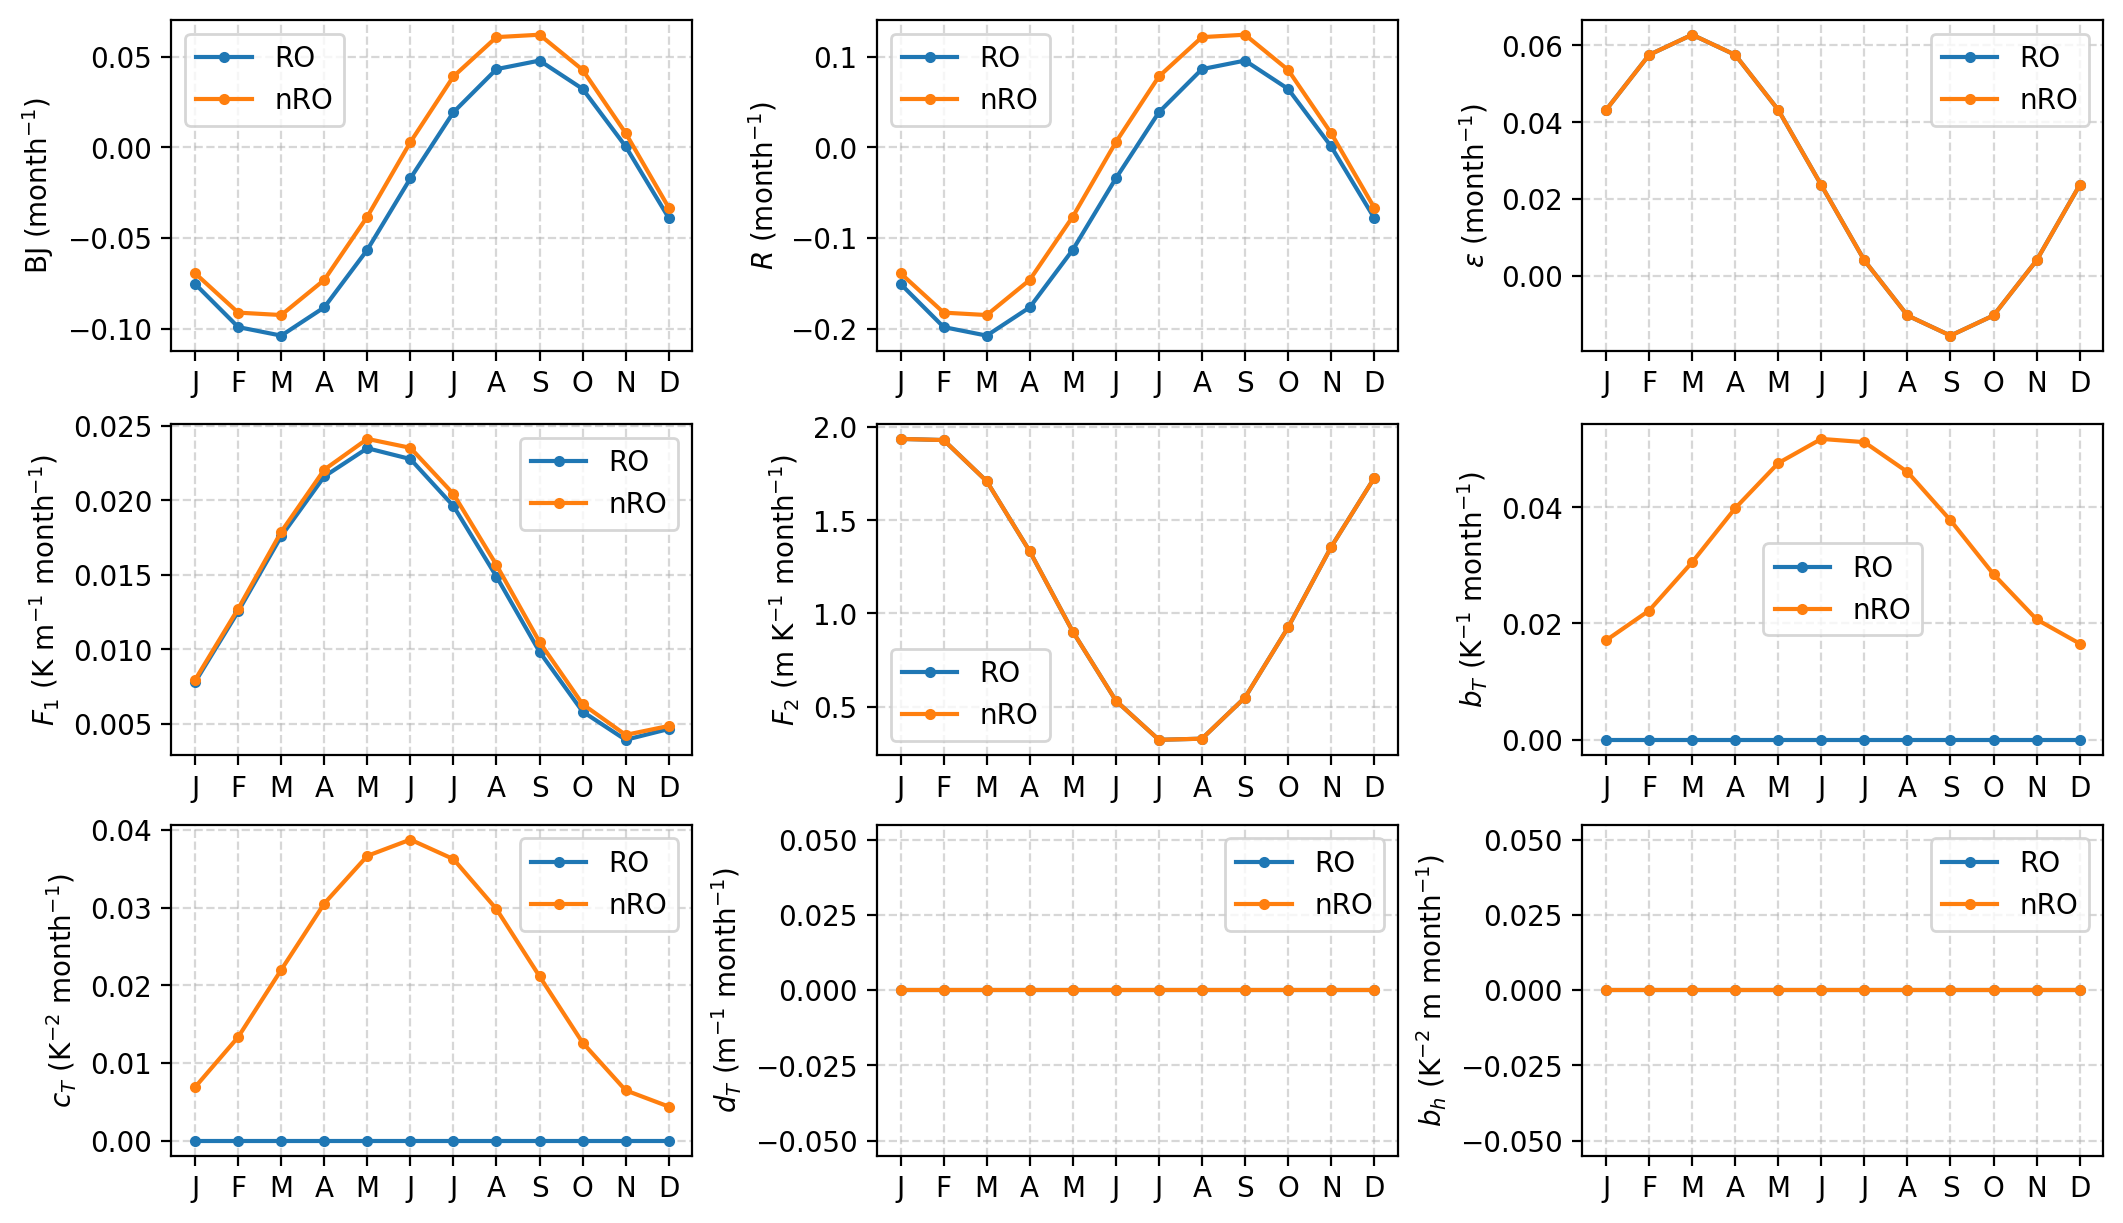

In [60]:
axes = pyCRO.plot_RO_par(par_fitted_obs, label='RO', ncol=3)
axes = pyCRO.plot_RO_par(par_fitted_obs2, label='nRO', ncol=3, ax=axes)


In [53]:
N = 12*200
NE = 100
T_out, h_out, noise_out = RO_solver(par_fitted_obs, IC=[0, 0], N=N, NE=NE, verbose=False)
xtime = xr.date_range('0001-01', periods=N, freq = 'MS', use_cftime=True)
member = np.arange(0, NE, step=1)
T_ds = xr.DataArray(T_out, dims={'time', 'member'}, coords={'time': xtime, 'member': member})
h_ds = xr.DataArray(h_out, dims={'time', 'member'}, coords={'time': xtime, 'member': member})
RO_ds = xr.Dataset({'Nino34': T_ds, 'WWV': h_ds})

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 2400, member: 100)
Coordinates:
  * time     (time) object 19kB 0001-01-01 00:00:00 ... 0200-12-01 00:00:00
  * member   (member) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    Nino34   (time, member) float64 2MB 0.0 0.0 0.0 0.0 ... 0.357 2.114 -1.012
    WWV      (time, member) float64 2MB 0.0 0.0 0.0 0.0 ... -7.696 1.43 -0.7313

In [61]:
T_out, h_out, noise_out = RO_solver(par_fitted_obs2, IC=[0, 0], N=N, NE=NE, verbose=False)
xtime = xr.date_range('0001-01', periods=N, freq = 'MS', use_cftime=True)
member = np.arange(0, NE, step=1)
T_ds = xr.DataArray(T_out, dims={'time', 'member'}, coords={'time': xtime, 'member': member})
h_ds = xr.DataArray(h_out, dims={'time', 'member'}, coords={'time': xtime, 'member': member})
nRO_ds = xr.Dataset({'Nino34': T_ds, 'WWV': h_ds})

In [63]:
RO_SD = RO_ds['Nino34'].groupby('time.month').std('time')
nRO_SD = nRO_ds['Nino34'].groupby('time.month').std('time')

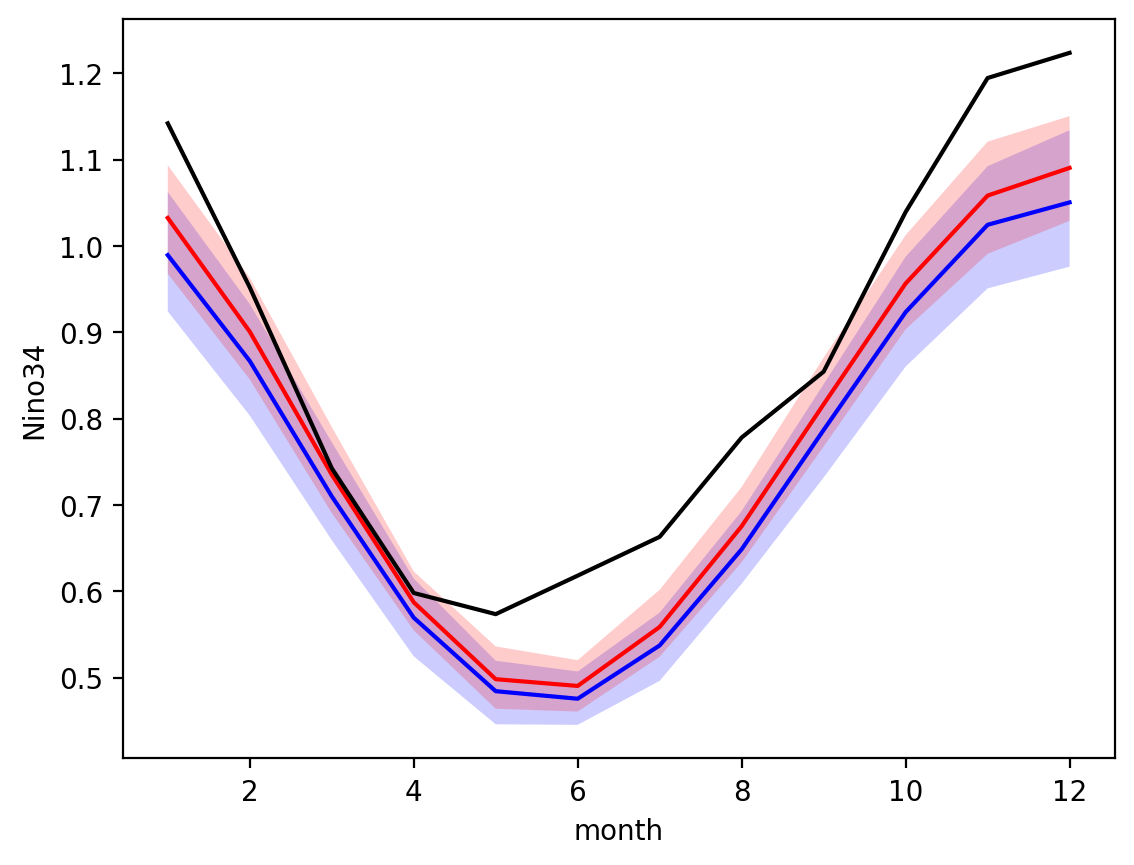

In [64]:
RO_SD.mean('member').plot(c='blue')
plt.fill_between(RO_SD.month, RO_SD.quantile(0.1, dim='member'), RO_SD.quantile(0.9, dim='member'), fc='blue', alpha=0.2)

nRO_SD.mean('member').plot(c='red')
plt.fill_between(nRO_SD.month, nRO_SD.quantile(0.1, dim='member'), nRO_SD.quantile(0.9, dim='member'), fc='red', alpha=0.2)


plt.plot(RO_SD.month, T_oras5.groupby('time.month').std('time'), c='k')